In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import bartz
from stochtree import BARTModel
from bart_playground import *

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import arviz as az
import time

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


In [4]:
from pmlb import fetch_data

X, y = fetch_data('1199_BNG_echoMonths', return_X_y=True)

In [5]:
X.shape

(17496, 9)

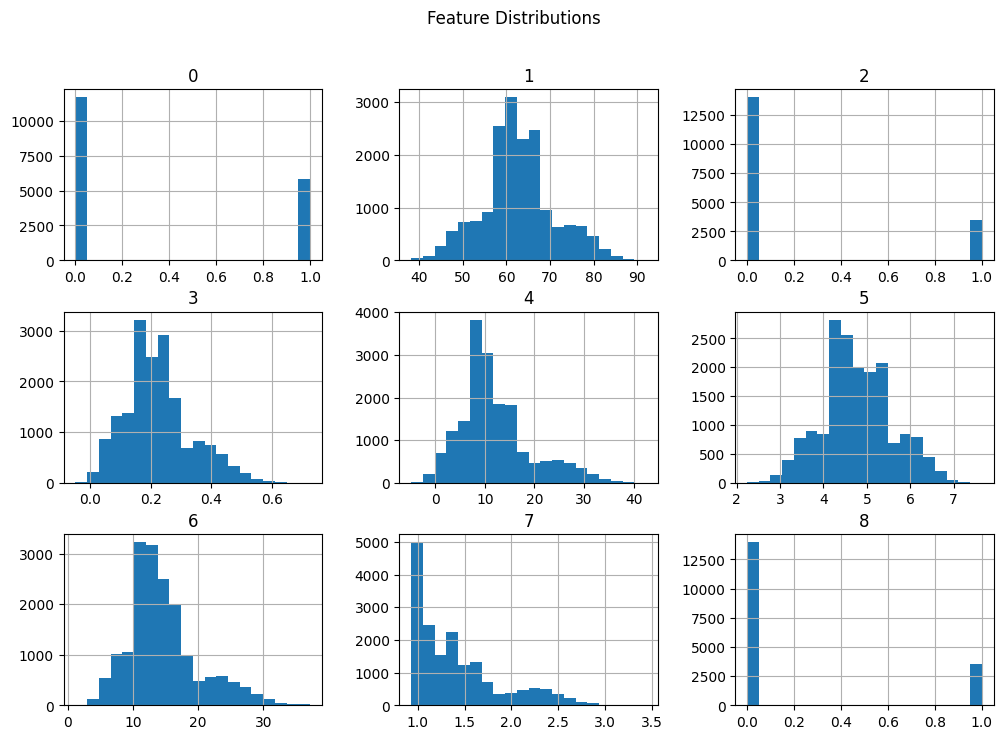

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

X_df = pd.DataFrame(X)
X_df.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

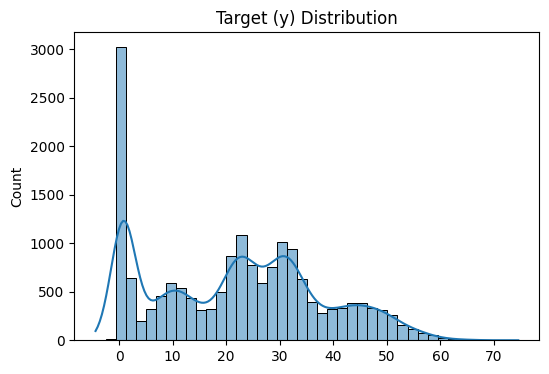

In [7]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

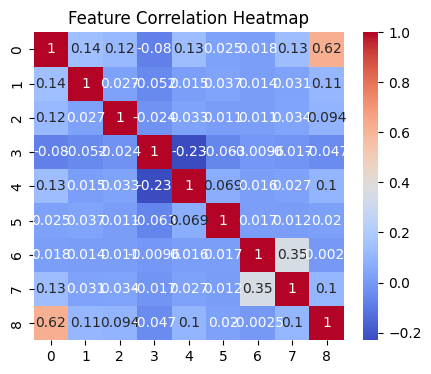

In [8]:
plt.figure(figsize=(5, 4))
corr = X_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [10]:
import comparison
import pandas as pd

rhat_df = comparison.gelman_rubin_r_compare(X, y, n_runs=5, n_chains=4, ndpost=500, nskip=200, n_trees=100, n_jobs=5)
mean_row = pd.DataFrame([rhat_df.mean()], index=["mean"])
std_row = pd.DataFrame([rhat_df.std()], index=["std"])
rhat_df_with_stats = pd.concat([rhat_df, mean_row, std_row])
print("Gelman-Rubin R̂ comparison matrix:")
print(rhat_df_with_stats)

Gelman-Rubin R̂ comparison matrix:
      MultiBART_Rhat_Sigma2  DefaultBART_Rhat_Sigma2  MultiBART_Rhat_RMSE  \
0                  1.057315                 1.130710             1.267259   
1                  1.087462                 1.058491             1.117395   
2                  1.017324                 1.076789             1.332836   
3                  1.083298                 1.120552             1.132521   
4                  1.046344                 1.038271             1.183670   
mean               1.058349                 1.084963             1.206736   
std                0.028715                 0.039709             0.091632   

      DefaultBART_Rhat_RMSE  
0                  1.224225  
1                  1.455548  
2                  1.340243  
3                  1.665525  
4                  1.423449  
mean               1.421798  
std                0.162966  


In [11]:
rhat_df.to_csv("results/real6_echoMonths_rhat.csv", index=False)

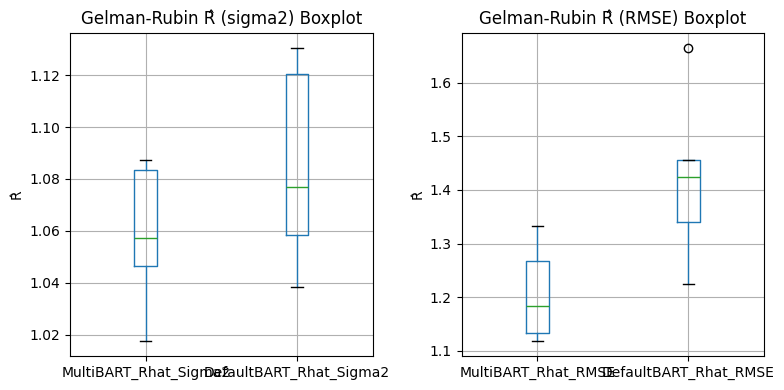

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# sigma2 boxplot
rhat_df[["MultiBART_Rhat_Sigma2", "DefaultBART_Rhat_Sigma2"]].boxplot(ax=axes[0])
axes[0].set_title("Gelman-Rubin R̂ (sigma2) Boxplot")
axes[0].set_ylabel("R̂")

# rmse boxplot
rhat_df[["MultiBART_Rhat_RMSE", "DefaultBART_Rhat_RMSE"]].boxplot(ax=axes[1])
axes[1].set_title("Gelman-Rubin R̂ (RMSE) Boxplot")
axes[1].set_ylabel("R̂")

plt.tight_layout()
plt.show()

c:\Learning\Phd\BART\bartpy\bart_env\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


test_mse:
       bart_mtmh        bart         btz         sto          rf         xgb
0     129.707448  132.276803  133.016456  135.101680  132.644593  139.323217
1     132.254639  134.358655  136.037556  137.013955  135.221860  142.761038
2     129.980934  131.793173  131.882945  135.059317  134.094306  139.665325
3     130.501977  135.196339  135.817750  135.257441  136.009708  142.592322
4     131.427615  133.372848  135.241712  136.496308  134.661939  142.401405
5     134.844211  135.953874  136.080584  137.596059  137.830949  144.409112
6     129.056718  130.987328  130.874453  133.009618  130.075645  143.240277
7     135.302084  136.237502  137.055098  138.014718  137.396965  146.489538
8     131.553720  133.205905  134.972311  136.750530  134.223581  144.326072
9     127.536224  128.398352  131.208674  129.620620  129.732321  139.346478
mean  131.216557  133.178078  134.218754  135.392025  134.189187  142.455479
std     2.440669    2.425476    2.264137    2.508430    2.735311  

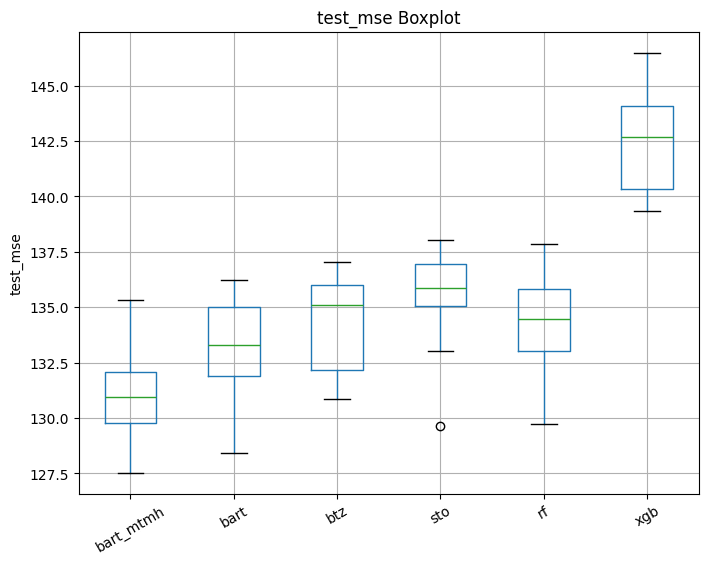

train_mse:
       bart_mtmh        bart         btz         sto         rf        xgb
0     119.665654  128.048067  130.082743  132.776250  18.837764  60.015500
1     118.943906  127.831868  129.939784  132.033723  18.643544  56.621137
2     120.630433  128.119673  128.730590  132.000851  18.682658  60.429968
3     118.702390  128.931956  130.271242  132.249731  18.630229  59.054943
4     119.824781  128.296528  129.799521  131.733678  18.653725  59.621118
5     119.050646  127.713572  129.273304  131.350033  18.613275  59.194286
6     120.304900  128.459558  130.150438  132.826368  18.792801  60.125988
7     118.022547  127.394037  129.762366  130.329378  18.492577  59.351145
8     120.300873  128.205318  129.369245  133.410636  18.767559  57.660885
9     120.283713  129.115878  132.886926  133.615893  18.807122  58.739761
mean  119.572984  128.211646  130.026616  132.232654  18.692126  59.081473
std     0.855778    0.527173    1.108950    0.982799   0.107524   1.171292



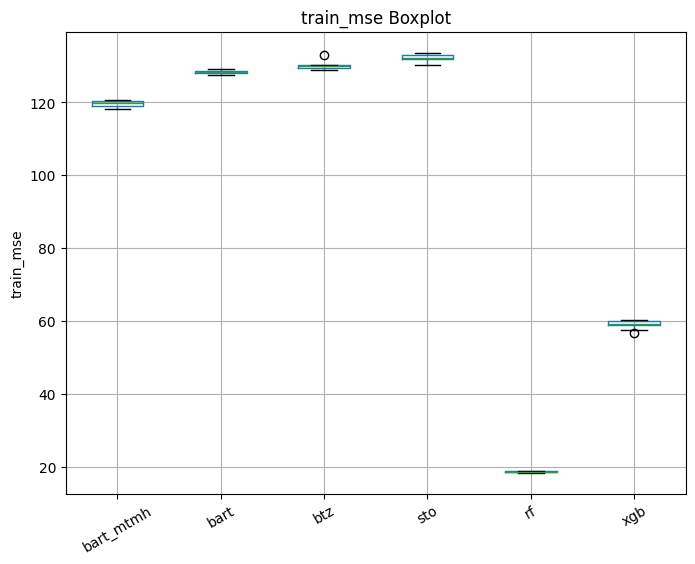

pi_length:
      bart_mtmh       bart        btz         sto
0     42.390896  43.070562  43.763709  522.111159
1     42.212890  42.894722  43.787992  528.633996
2     42.458393  43.049888  43.722274  521.085914
3     42.244945  43.207445  43.835736  525.704883
4     42.430078  42.971336  43.818273  527.183633
5     42.219631  42.818866  43.500953  517.469191
6     42.472623  43.165094  43.635368  518.697843
7     42.060939  42.761146  43.725788  513.402098
8     42.500360  43.118158  43.743267  534.156139
9     42.393822  43.173545  44.099566  530.778344
mean  42.338458  43.023076  43.763293  523.922320
std    0.144705   0.155734   0.152984    6.486639



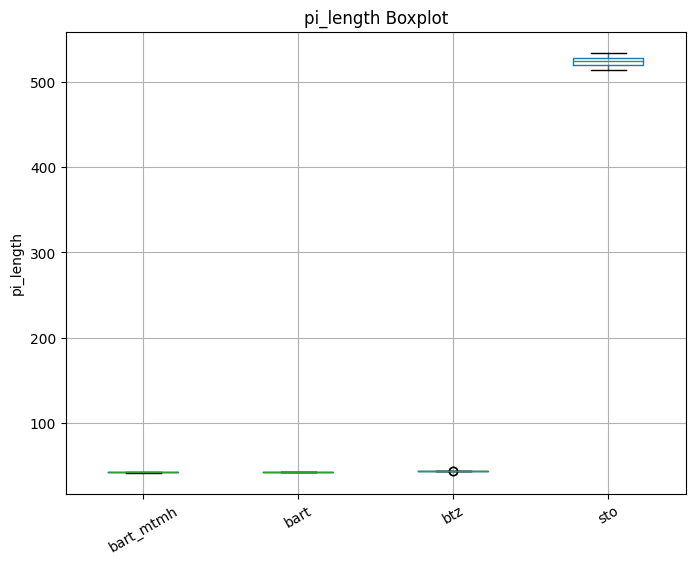

coverage:
      bart_mtmh      bart       btz       sto
0      0.923182  0.923182  0.925240  0.999314
1      0.918153  0.917238  0.925011  0.999086
2      0.921582  0.924554  0.927755  0.999543
3      0.922725  0.921353  0.921582  1.000000
4      0.917924  0.920896  0.927069  0.999314
5      0.918610  0.920668  0.921811  0.999771
6      0.926840  0.928669  0.932099  0.999771
7      0.914037  0.917924  0.923868  0.999086
8      0.918153  0.921125  0.924554  0.999543
9      0.922954  0.928212  0.937128  0.999314
mean   0.920416  0.922382  0.926612  0.999474
std    0.003689  0.003844  0.004793  0.000306



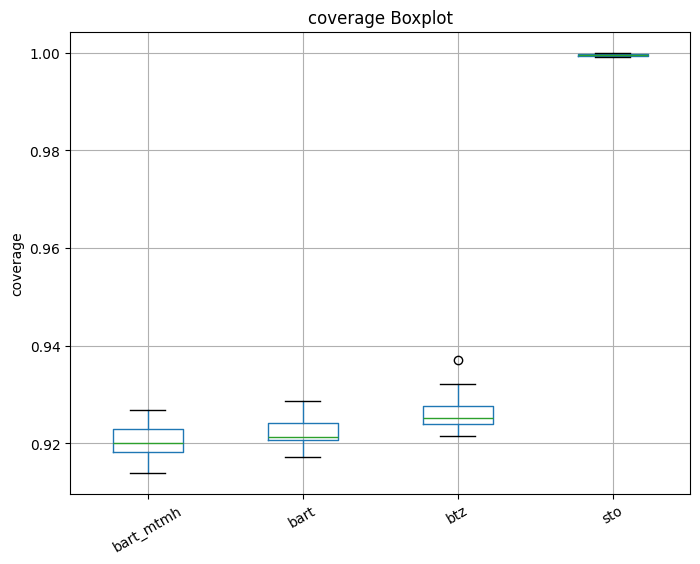

train_time:
      bart_mtmh      bart       btz        sto         rf       xgb
0     43.023814  5.091853  7.023600  14.338085  10.506273  0.193232
1     43.459338  5.009606  7.971491  13.956645  10.489110  0.188555
2     43.378644  5.140011  8.051707  13.886273  10.532826  0.239412
3     43.252927  5.044632  7.696925  14.283457  10.710009  0.247928
4     43.150485  5.128052  7.511918  14.057159  10.541534  0.183015
5     45.180839  5.607390  7.265554  14.527768  10.516685  0.191576
6     45.178220  5.660004  7.212086  14.440651  10.628367  0.159659
7     45.731122  5.696121  7.775335  13.967957  10.840099  0.176596
8     45.249469  5.693793  7.688125  13.938897  10.718915  0.187051
9     45.604286  5.788239  8.323764  13.809078  10.591770  0.182746
mean  44.320914  5.385970  7.652050  14.120597  10.607559  0.194977
std    1.144821  0.324649  0.406751   0.254125   0.115540  0.027436



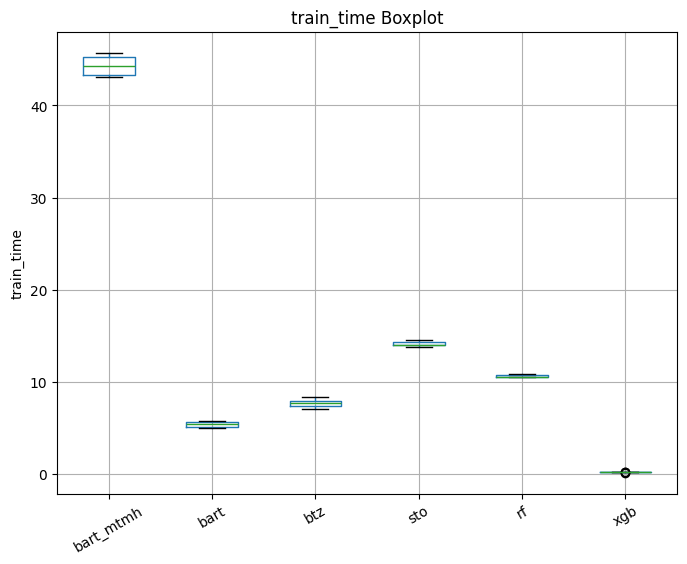

In [13]:
import matplotlib.pyplot as plt

mse_results = comparison.bart_mse_comparison(X, y, n_runs=10, n_skip=100, n_post=100, n_trees=100, n_jobs=5)
for k, v in mse_results.items():
    mean_row = pd.DataFrame([v.mean()], index=["mean"])
    std_row = pd.DataFrame([v.std()], index=["std"])
    v_with_stats = pd.concat([v, mean_row, std_row])
    print(f"{k}:\n{v_with_stats}\n")
    
    plt.figure(figsize=(8, 6))
    v.boxplot()
    plt.title(f"{k} Boxplot")
    plt.ylabel(k)
    plt.xticks(rotation=30)
    plt.show()

In [14]:
for k, v in mse_results.items():
    csv_name = f"results/real6_echoMonths_{k}.csv"
    v.to_csv(csv_name, index=False)

## Multi-tries

In [9]:
from multi_tries import multi_tries_performance
import pandas as pd

csv_path = "results/real6_echoMonths_tries.csv"
existing_df = None

if os.path.exists(csv_path):
    existing_df = pd.read_csv(csv_path)

df = multi_tries_performance(
    X, y,
    multi_tries_list=[1,5,10,50,100],
    n_runs=5, n_chains=4,
    ndpost=500, nskip=200, n_trees=100, n_jobs=5
)

if existing_df is not None:
    df = pd.concat([existing_df, df], ignore_index=True)
    df = df.sort_values(by='multi_tries', ascending=True).reset_index(drop=True)

df.to_csv("results/real6_echoMonths_tries.csv", index=False)

In [10]:
print(df)

   multi_tries  Rhat_Sigma2  Rhat_RMSE    Test_MSE  Coverage   Train_Time
0            1     1.102165   1.532045  132.114216  0.937494    34.357931
1            5     1.065901   1.260533  130.641365  0.935117    89.344948
2           10     1.058349   1.206736  129.768612  0.934659   161.807393
3           50     1.096773   1.169740  129.453790  0.932876   751.379347
4          100     1.090577   1.186495  130.616334  0.932739  1530.208780
